In [13]:
import os
os.getcwd()

'D:\\Geosciences_Project\\Nowcasting_OF\\nowcasting_script'

In [ ]:
root_path = os.getcwd()

In [7]:
# Import Necessary Libraries
import os
import numpy as np
from datetime import datetime

import pysteps
# Import utility functions from the repository
import utility

In [7]:
# Define the data directory for the repository data
data_path = os.path.join(root_path, "Data")
# Define metadata files
metadata_X = utility.get_matadata(os.path.join(data_path, "radarmappatipo.tif"), type="X")
# metadata_C = utility.get_matadata(os.path.join(data_path, "civilpromap.tiff"), type="C")

In [11]:
# Choose the event date
date = datetime.strptime("20191024_0415", "%Y%m%d_%H%M")
# Define parameters for X-band radar data
data_source_X = "UNICA_SG"
f_ext_X = "png"
# Load X-band radar data
R_X, metadata_X = utility.import_files_by_date(date, data_path, data_source_X, f_ext_X, metadata_X, timestep=5, num_prev_files=9)

In [12]:
# Noise removal using Watershed technique
R_X_clean = np.empty_like(R_X)
for t in range(R_X.shape[0]):
    R_X_clean[t, :, :] = utility.noise_remove(R_X[t, :, :], type="Watershed")

In [13]:
# Convert Digital Number to Reflectivity (dBZ)
R_X_dbz = utility.dn_to_dbz(R_X_clean)
# Convert to rain rate
R_X_R, metadata_X = pysteps.utils.conversion.to_rainrate(R_X_dbz, metadata_X)
# Log-transform the data
image_R, metadata_X = pysteps.utils.transformation.dB_transform(R_X_R, metadata_X, threshold=0.01, zerovalue=-15.0)

In [14]:
## Print metadata
# from pprint import pprint
# pprint(metadata_X)

In [15]:
# Estimate motion field using Lucas-Kanade optical flow
import matplotlib.pyplot as plt
from pysteps.visualization import plot_precip_field, quiver
oflow_method = pysteps.motion.get_method("LK")
V1 = oflow_method(image_R[-3:, :, :])

C:\Users\Utente\anaconda3\envs\avi_ppt_dwnsc\Lib\site-packages\pysteps\visualization\utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\avi_ppt_dwnsc\Lib\site-packages\pysteps\visualization\utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


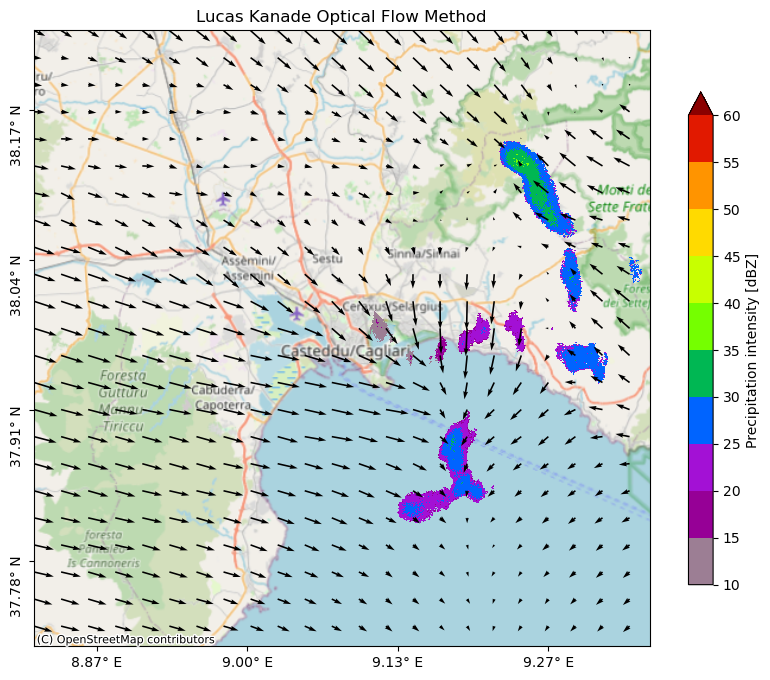

In [16]:
# Plot precipitation field and motion field
fig, ax = plt.subplots(figsize=(10, 8))
# Precipitation field
plot_precip_field(
    R_X_dbz[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_X, 
    units="dBZ", 
    title="Lucas Kanade Optical Flow Method", 
    ax=ax, 
    colorscale="pysteps"
)
# Motion field (quiver plot)
quiver(V1, geodata=metadata_X, step=45, ax=ax)
utility.plot_modification(ax,metadata_X)